In [1]:
# === Core scientific libraries ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scipy (scientific functions) ===
from scipy import stats
from scipy.stats import norm, expon
from scipy.special import expit

# === Statsmodels (econometrics / statistical modeling) ===
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS

# === Scikit-learn: preprocessing ===
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# === Scikit-learn: models (supervised learning) ===
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# === Scikit-learn: model selection & evaluation ===
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.utils import resample

# === Causal inference (DoubleML) ===
import doubleml as dml
from doubleml import DoubleMLData, DoubleMLPLR

# === Other machine learning libraries ===
import GPy

# === Parallelization ===
from joblib import Parallel, delayed

# === Utilities ===
import itertools


In [2]:
# Assigning the current directory to this_dir
from pathlib import Path
this_dir = Path (".")

# make it absolute
print(this_dir.resolve())

C:\Users\Anna\master_thesis\master_thesis


## Data Creation

Now I will collect data files, correct them with the list of selected countries* and make long format to make it more convenient for Machine Learning.

*These countries mostly have no NA values in all datasets.   
Nevertheless, there were some correction for Ireland:

In dataset related to municipal waste per capita:
- The average was taken for 2015
- Total municipal wastes for 2 last years were taken from here https://www.cso.ie/en/releasesandpublications/ep/p-eii/environmentalindicatorsireland2023/waste/#:~:text=Municipal%20waste%20generated%20in%20Ireland%20was%203.2%20million%20tonnes%20in,kilogrammes%20per%20capita%20in%202021 and waste per capita was calculated depending on Ireland population.


In [3]:
selected_countries = ["Belgium", "Austria", "Czechia", "Ireland", "Cyprus", "Hungary", "Serbia", "Switzerland", 
                       "Sweden", "Denmark", "France", "Spain", "Netherlands", "Norway", "Germany", "Italy",
                       "Poland", "Lithuania", "Luxembourg", "Portugal", "Latvia", "Malta", 
                       "Slovenia", "Estonia", "Finland", "Croatia", "Greece"]

### Policy

I will start with the Policy dataset where, for countries that approved Policy, the value of 1 will be assigned from that year onwards. If no Policy was adopted, the value will be 0.

In [4]:
data_file_p = this_dir / "data" / "policy.xlsx"
data_file_p.resolve()
df_policy = pd.read_excel(data_file_p, sheet_name="Sheet1")

from help_func import convert_to_long_format
# Converting into long format
df_policy_long = convert_to_long_format(df_policy, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='Policy')

print(df_policy_long)

         Country  Year  Policy
0        Belgium  2014       0
1        Czechia  2014       0
2        Denmark  2014       0
3        Germany  2014       0
4        Estonia  2014       0
..           ...   ...     ...
238      Finland  2022       0
239       Sweden  2022       1
240       Norway  2022       1
241  Switzerland  2022       0
242       Serbia  2022       1

[243 rows x 3 columns]


In [5]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"

latex_table_p = df_policy.to_latex(index=False)

# Direction to file where will be stored Latex-table
latex_output_file = obtained_data_dir / "policy_table.tex"

with open(latex_output_file, "w", encoding="utf-8") as f:
    f.write(latex_table_p)

### Municipal Wastes

Afterwards, I will move on to the data on municipal waste, which is measured in kilograms per capita.

In [6]:
data_file_w = this_dir / "data" / "env_waste_mun.xlsx"
data_file_w.resolve()
data_was = pd.read_excel(data_file_w, sheet_name="Sheet 1", na_values=':')
data_was = data_was.rename(columns={"TIME": "Country"})

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

filtered_data_was = data_was[data_was["Country"].isin(selected_countries)]

from help_func import convert_to_long_format

filtered_data_was_long = convert_to_long_format(filtered_data_was, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='waste_per_cap')

print(filtered_data_was_long)

         Country  Year  waste_per_cap
0        Belgium  2013          436.0
1        Czechia  2013          307.0
2        Denmark  2013          813.0
3        Germany  2013          615.0
4        Estonia  2013          293.0
..           ...   ...            ...
265      Finland  2022          522.0
266       Sweden  2022          395.0
267       Norway  2022          768.0
268  Switzerland  2022          677.0
269       Serbia  2022          473.0

[270 rows x 3 columns]


 C:\Users\Anna\AppData\Local\Temp\ipykernel_12128\1444614643.py:7: UserWarning:Ignoring `palette` because no `hue` variable has been assigned.


<Figure size 1000x600 with 0 Axes>

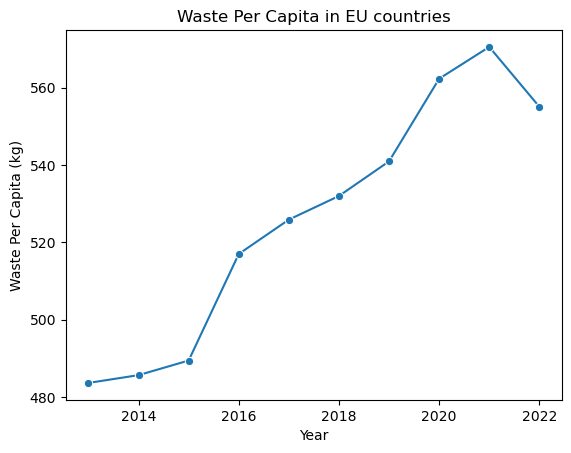

In [8]:
# Аggregation
avg_trends_waste = filtered_data_was_long.groupby(['Year'])['waste_per_cap'].mean().reset_index()

# Waste Per Capita
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', 
             palette=["blue"], marker="o")

plt.title('Waste Per Capita in EU countries')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
plt.show()

I will analyze this variable in more detail, so we need data for all years from 2013 to 2022 (later, due to the limitations of some datasets, data from 2015 to 2022 will be used). I will start with analysis unexpected outliers in waste growth for any given year.

<Axes: xlabel='Year'>

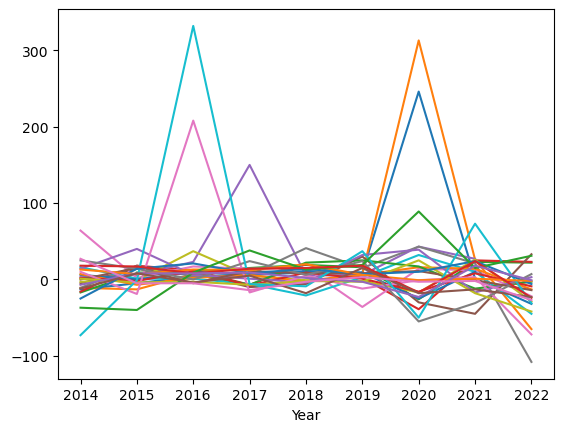

In [9]:
plottable = filtered_data_was_long.pivot(columns=['Country'], index='Year')
diff = plottable.diff()
diff.plot(legend=False)

This graph shows waste change YoY per country. As we can see there are 4 extremely high surges for 4 different countries that translate to the step changes in the waste levels (see graph below). The most appropriate explanation is that for these countries methodology for waste accounting was changed, because, first, the change is **too abrupt and massive** (25-30% in a year) to be caused by a natural non-catastrophic course of events; second, after the step change the graph **resumes its general pattern** of behavior, albeit at a higher base level; third, in each case, **none of neighboring countries see changes** in waste levels of a comparable magnitude.

Now I will find which countries they are.

<Axes: xlabel='Year'>

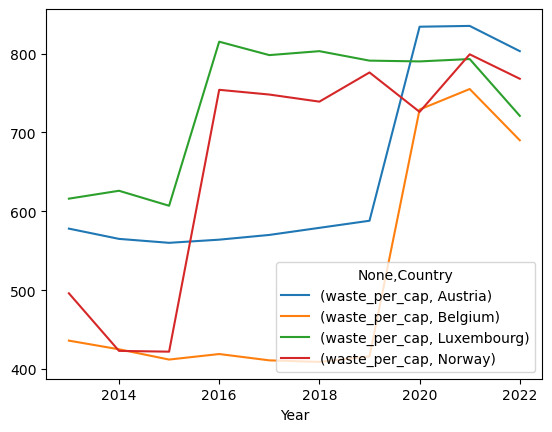

In [10]:
plottable.loc[:, diff.max() > 200].plot()

In [11]:
# repair waste data for Austria, Belgium, Norway, Luxembourg before the following years:
repairs = [('Austria', 2020), ('Belgium', 2020), ('Norway', 2016), ('Luxembourg', 2016)] 

The most sensible option to deal with these countries' data  is to leave only more recent data points, for which the new, presumably corrected methodology was used.

In [12]:
# Leave only more recent data (with higher levels) asuming it was collected with improved methodology

fdwl = filtered_data_was_long
for country, first_correct_yr in repairs:
    fdwl.drop(fdwl[(fdwl.Country == country) & (fdwl.Year < first_correct_yr)].index, inplace=True)

# Ensure, for example, that Austria lost all years before 2020 
filtered_data_was_long[filtered_data_was_long.Country == 'Austria']

,Country,Year,waste_per_cap
207,Austria,2020,834.0
234,Austria,2021,835.0
261,Austria,2022,803.0


<Axes: xlabel='Year'>

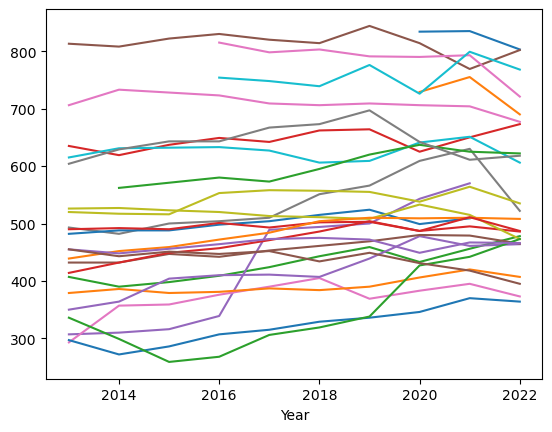

In [13]:
filtered_data_was_long.pivot(columns=['Country'], index='Year').plot(legend=False)

### Covariates

Let's gather data for the covariates   

#### Environmental Taxes

In [14]:
data_file_t = this_dir / "data" / "env_tax_gdp_per.xlsx"
data_file_t.resolve()
data_etax = pd.read_excel(data_file_t, sheet_name="Sheet 1")
data_etax = data_etax.rename(columns={"TIME": "Country"})

filtered_data_etax = data_etax[data_etax["Country"].isin(selected_countries)]

In [15]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_etax_long = convert_to_long_format(filtered_data_etax, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='env_tax')
print(filtered_data_etax_long)

         Country  Year env_tax
0        Belgium  2014    2.54
1        Czechia  2014    2.12
2        Denmark  2014       4
3        Germany  2014    1.99
4        Estonia  2014    2.66
..           ...   ...     ...
229     Slovenia  2022    2.87
230      Finland  2022    2.43
231       Sweden  2022    1.91
232       Norway  2022    1.29
233  Switzerland  2022    1.27

[234 rows x 3 columns]


#### Unemployment

In [16]:
data_file_u = this_dir / "data" / "unemp_percent.xlsx"
data_file_u.resolve()
data_unemp = pd.read_excel(data_file_u, sheet_name="Sheet 1")
data_unemp = data_unemp.rename(columns={"TIME": "Country"})

filtered_data_unemp = data_unemp[data_unemp["Country"].isin(selected_countries)]
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[1:2], axis=1)
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[-1], axis=1)


In [17]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_unemp_long = convert_to_long_format(filtered_data_unemp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='unemp_rate')


print(filtered_data_unemp_long)

         Country  Year unemp_rate
0        Belgium  2015        8.7
1        Czechia  2015        5.1
2        Denmark  2015        6.3
3        Germany  2015        4.4
4        Estonia  2015        6.4
..           ...   ...        ...
211      Finland  2022        6.8
212       Sweden  2022        7.5
213       Norway  2022        3.2
214  Switzerland  2022        4.1
215       Serbia  2022        9.6

[216 rows x 3 columns]


#### Real Expenditures

In [18]:
data_file_e = this_dir / "data" / "real_exp_pc.xlsx"
data_file_e.resolve()
data_exp = pd.read_excel(data_file_e, sheet_name="Sheet 1")
data_exp = data_exp.rename(columns={"TIME": "Country"})

filtered_data_exp = data_exp[data_exp["Country"].isin(selected_countries)]
filtered_data_exp = filtered_data_exp.drop(filtered_data_exp.columns[-1], axis=1)


In [19]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_exp_long = convert_to_long_format(filtered_data_exp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='rexp_per_cap')

print(filtered_data_exp_long)

         Country  Year rexp_per_cap
0        Belgium  2014        21300
1        Czechia  2014        14500
2        Denmark  2014        21400
3        Germany  2014        22500
4        Estonia  2014        12700
..           ...   ...          ...
238      Finland  2022        25500
239       Sweden  2022        26000
240       Norway  2022        29700
241  Switzerland  2022        27300
242       Serbia  2022        12300

[243 rows x 3 columns]


#### Urbanization

In [20]:
data_file_ur = this_dir / "data" / "p_urbanization.xlsx"
data_file_ur.resolve()
data_urb = pd.read_excel(data_file_ur, sheet_name="Data")
data_urb = data_urb.rename(columns={"TIME": "Country"})

filtered_data_urb = data_urb[data_urb["Country"].isin(selected_countries)]


In [21]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_urb_long = convert_to_long_format(filtered_data_urb, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='urb_ind')

print(filtered_data_urb_long)

         Country  Year  urb_ind
0        Belgium  2014   97.833
1        Denmark  2014   87.410
2        Germany  2014   77.190
3        Estonia  2014   68.269
4         Sweden  2014   86.247
..           ...   ...      ...
238      Hungary  2022   72.552
239       Serbia  2022   56.873
240  Switzerland  2022   74.092
241       Norway  2022   83.664
242       Greece  2022   80.357

[243 rows x 3 columns]


### Merging

In [22]:
# Merging tables on the columns 'Country' and 'Year'
df_combined1 = pd.merge(filtered_data_was_long, df_policy_long,
                       on=['Country', 'Year'], how='inner')

# Adding other covariates in a similar way
df_combined2 = pd.merge(df_combined1, filtered_data_etax_long, on=['Country', 'Year'], how='inner')
df_combined3 = pd.merge(df_combined2, filtered_data_unemp_long, on=['Country', 'Year'], how='inner')
df_combined4 = pd.merge(df_combined3, filtered_data_exp_long, on=['Country', 'Year'], how='inner')
df = pd.merge(df_combined4, filtered_data_urb_long, on=['Country', 'Year'], how='inner')

df['waste_per_cap'] = pd.to_numeric(df['waste_per_cap'], errors='coerce')

print(df)

         Country  Year  waste_per_cap  Policy env_tax unemp_rate rexp_per_cap  \
0        Czechia  2015          316.0       0    2.05        5.1        14800   
1        Denmark  2015          822.0       0    3.97        6.3        21800   
2        Germany  2015          632.0       0    1.92        4.4        22800   
3        Estonia  2015          359.0       0    2.73        6.4        13300   
4        Ireland  2015          571.0       0    1.89        9.9        17800   
..           ...   ...            ...     ...     ...        ...          ...   
191     Slovenia  2022          487.0       1    2.87          4        20200   
192      Finland  2022          522.0       0    2.43        6.8        25500   
193       Sweden  2022          395.0       1    1.91        7.5        26000   
194       Norway  2022          768.0       1    1.29        3.2        29700   
195  Switzerland  2022          677.0       0    1.27        4.1        27300   

     urb_ind  
0     73.477

In [23]:
# Create feature 'Group': 1 if a country has ever adopted 'Policy' , 0 - never adopted 'Policy' 
new_cols = list(df.columns)
new_cols.insert(4, 'Group')
policy_per_country = df.groupby('Country')['Policy'].max()
df['Group'] = df['Country'].map(policy_per_country)
df = df[new_cols]

In [24]:
# Preview example of df
df[df.Country.isin(['Croatia', 'Denmark'])]

,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
1,Denmark,2015,822.0,0,0,3.97,6.3,21800,87.526
8,Croatia,2015,398.0,0,1,4.21,16.2,11600,56.155
23,Denmark,2016,830.0,0,0,3.91,6,21800,87.642
30,Croatia,2016,409.0,0,1,4.31,13,12100,56.403
47,Denmark,2017,820.0,0,0,3.67,5.8,22700,87.757
54,Croatia,2017,424.0,0,1,4.33,11.1,12700,56.667
71,Denmark,2018,814.0,0,0,3.62,5.1,23500,87.874
78,Croatia,2018,443.0,1,1,4.36,8.3,13300,56.947
95,Denmark,2019,844.0,0,0,3.3,5,23700,87.994
102,Croatia,2019,459.0,1,1,4.24,6.6,13900,57.242


In [25]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data.xlsx"
df.to_excel(output_file, index=False)

In [ ]:
df_preview = pd.concat([df.head(5), df.tail(5)])

latex_table_all = df_preview.to_latex(index=False)

latex_output_file_1 = obtained_data_dir / "f_table.tex"

with open(latex_output_file_1, "w", encoding="utf-8") as f:
    f.write(latex_table_all)

## Data Analysis and Preprocessing

Let's visualize the general trend of the waste level for each country group: plot mean waste of those countries who adopted the Policy versus those who did not.

<Figure size 1000x600 with 0 Axes>

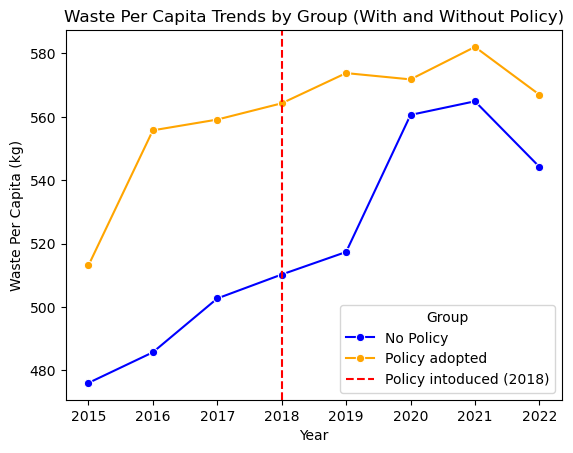

In [27]:
# Аggregation
avg_trends_waste = df.groupby(['Year', 'Group'])['waste_per_cap'].mean().reset_index()

# Waste Per Capita
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', hue='Group', 
             palette=["blue", "orange"], marker="o")

plt.axvline(2018, color='red', linestyle='--', label='Policy intoduced (2018)')
plt.title('Waste Per Capita Trends by Group (With and Without Policy)')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'No Policy'
labels[1] = 'Policy adopted'
plt.legend(title='Group', handles=handles, labels=labels)
plt.show()

Conclusion: There is a tendency in attitude to migration for countries who were willing to sign the document and who - not. I am assuming that each country's decision is based on their general migration policy which is stay the same from the begininng. 
Now I will switch from problem related to finding ATE of implementing Policy in a particular year to problem related to finding ATE of having such type of Policy during several years.

*NB. The adoption of the policy does not lead to an impact, as these changes will not show the effect within our short observation period. The fact that the policy exists classifies a country into a certain group.*

Also, despite having years, we are not considering time dependency and do not use years as a factor/time variable. We do not consider the change of waste generation (we look at the absolute value), and we do not care how the amount of waste has changed compared to the previous year; each value does not depend on the previous one (which is the definition of time dependency), meaning the process is stationary. 

*NB. Year as a factor does not have impact which was checked for the interest later.*

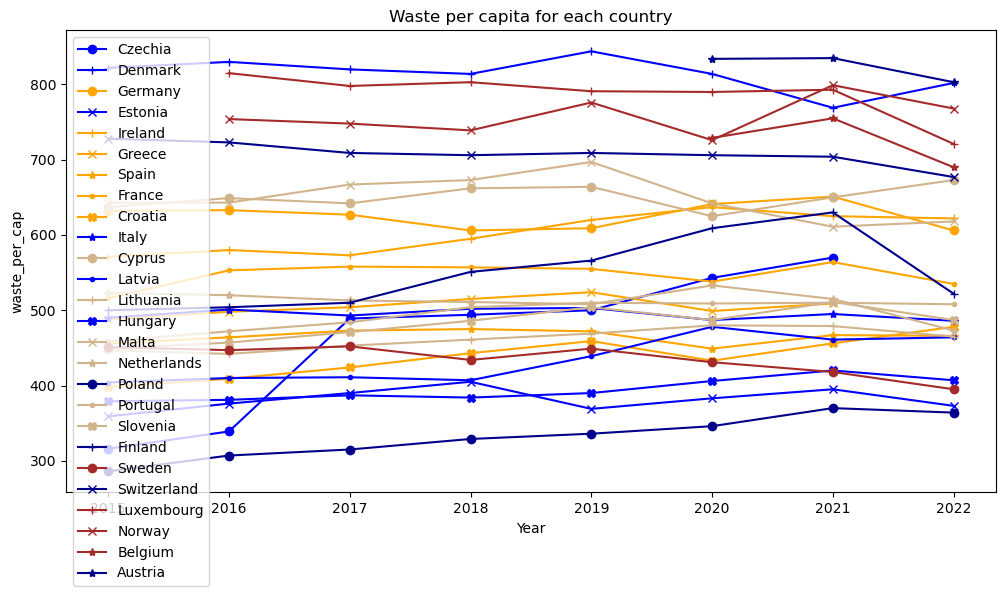

In [28]:
# Graph of waste per year for each country

countries = df["Country"].unique()
plt.figure(figsize=(12, 6))

policy_colors_markers = itertools.cycle(itertools.product(('orange', 'tan', 'brown'), ('o', '+', 'x', '*', '.', 'X')))
no_policy_colors_markers = itertools.cycle(itertools.product(('blue', 'darkblue', 'cornflowerblue'), ('o', '+', 'x', '*', '.', 'X')))

y = 'waste_per_cap'
x = 'Year'
for country in countries:
    subset = df[df["Country"] == country]
    #color = "orange" if subset["Policy"].iloc[0] == 1 else "blue" 
    if  subset["Group"].iloc[0] == 1:
        color, marker = next(policy_colors_markers)
    else:
        color, marker = next(no_policy_colors_markers)
    plt.plot(subset[x], subset[y], marker=marker, label=country, color=color)

plt.xlabel(x)
plt.ylabel(y)
plt.title("Waste per capita for each country")
plt.legend()
plt.show()

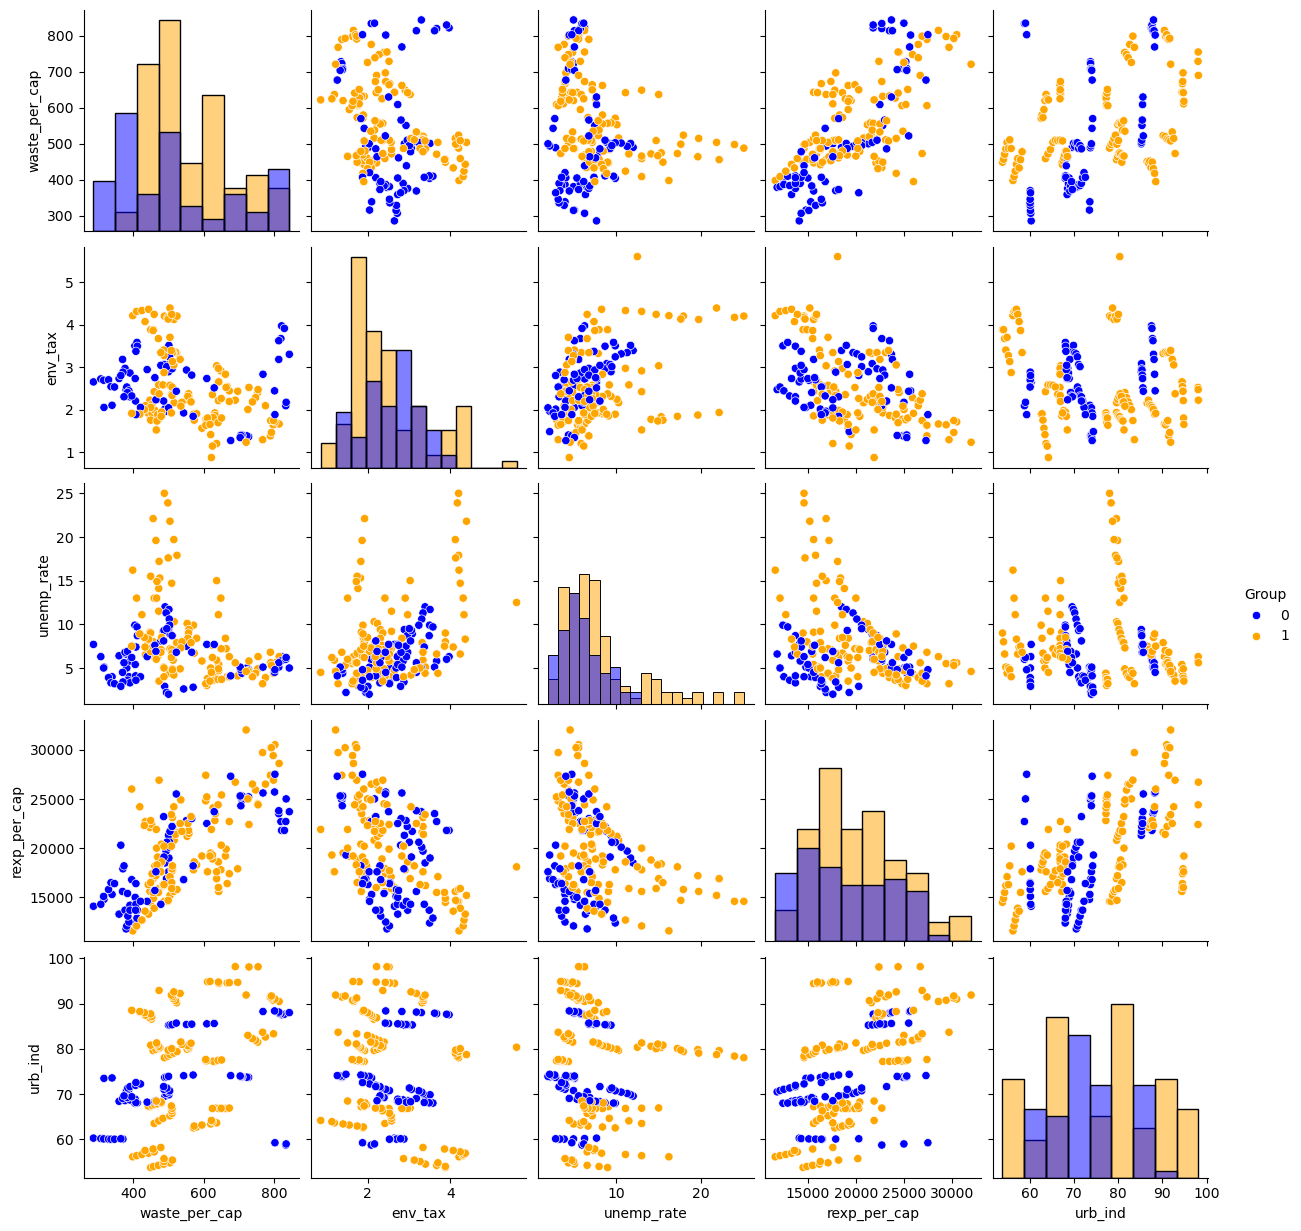

In [29]:
# 2. Correlation graphs (pairplot)

X_factors = ["env_tax", "unemp_rate", "rexp_per_cap", "urb_ind"]
sns.pairplot(df, vars=["waste_per_cap"] + X_factors, hue="Group", palette=["blue", "orange"], diag_kind='hist')
plt.show()

**Relationships of Waste per Capita with Covariates**:

- Waste per Capita vs. Environmental Tax (*env_tax*)

There is no clear linear relationship, but countries with lower environmental taxes tend to be more not migrant-friendly.

- Waste per Capita vs. Unemployment Rate (*unemp_rate*)

Stricter migration countries tend to have lower unemployment rates, while migrant-friendly countries show a wider range of unemployment levels.
A weak negative correlation is visible: countries with higher unemployment generally have lower waste per capita.

- Waste per Capita vs. Real Expenditure per Capita (*rexp_per_cap*)

Strong positive correlatio: —richer countries generate more waste per capita.
Migrant-friendly countries generally have higher expenditures and higher waste per capita, while stricter migration countries show more variation.

- Waste per Capita vs. Urbanization Index (*urb_ind*)

A weak positive trend suggests that urbanized nations might produce more waste due to denser populations and higher consumption rates. Also, vertical composistions of dots show that the level of urbanization in countries usually stays the same while level of waste increases.

**Relationships between Covariates**:

There are mostly no interesting relations, however we can see two:

- Real Expenditure per Capita vs. Unemployment Rate (*unemp_rate*)

A strong negative correlation is observed: wealthier countries tend to have lower unemployment.
Migrant-friendly countries generally have lower unemployment rates, while stricter migration countries show more variability.

- Real Expenditure per Capita vs. Environmental Tax (*env_tax*)

Wealthier countries tend to have higher environmental taxes, and migrant-friendly countries generally have higher taxes than stricter migration countries (blue points).

Before jumping in ML and DML parts it is needed to apply scaling (I chose MinMax Scaler): 

### MinMax Scaler Formula:

The MinMax Scaler is used to normalize or scale data within a specific range (between 0 and 1). The formula for MinMax scaling is:

$$ 
X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

In [30]:
df_n = df.copy() 

# Select columns to be standardized
columns_to_scale = ['env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']

# Keep non-standardized columns separately
other_columns = ['Country', 'Year', 'waste_per_cap', 'Policy', 'Group']

# Standardize only the selected columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_n[columns_to_scale])

# Convert the standardized data back to a DataFrame
to_scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df_n.index)

# Combine standardized and non-standardized columns
scaled_df = pd.concat([df_n[other_columns], to_scaled_df], axis=1)
scaled_df['waste_per_cap'] = pd.to_numeric(scaled_df['waste_per_cap'], errors='coerce')

scaled_df = scaled_df.dropna()
scaled_df 


,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
0,Czechia,2015,316.0,0,0,0.249471,0.134783,0.156863,0.443884
1,Denmark,2015,822.0,0,0,0.655391,0.186957,0.500000,0.760502
2,Germany,2015,632.0,0,1,0.221987,0.104348,0.549020,0.527788
3,Estonia,2015,359.0,0,0,0.393235,0.191304,0.083333,0.329825
4,Ireland,2015,571.0,0,1,0.215645,0.343478,0.303922,0.197354
...,...,...,...,...,...,...,...,...,...
191,Slovenia,2022,487.0,1,1,0.422833,0.086957,0.421569,0.044397
192,Finland,2022,522.0,0,0,0.329810,0.208696,0.681373,0.718922
193,Sweden,2022,395.0,1,1,0.219873,0.239130,0.705882,0.782273
194,Norway,2022,768.0,1,1,0.088795,0.052174,0.887255,0.673465


In [31]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data_policy_scaled.xlsx"
scaled_df.to_excel(output_file, index=False)

## ML Workflow

I will start with standard OLS regressions to first investigate whether a country's group affiliation affects waste generation overall. Then, I will analyze the impact of each covariate on waste per capita by running separate regressions for each group.

In [32]:
# Does Group influence waste?

ml_df = scaled_df

y = ml_df['waste_per_cap'] 
X_new = ml_df[['Group']]
X_new = sm.add_constant(X_new)
ols_model = sm.OLS(y, X_new).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.173
Date:                Mon, 18 Aug 2025   Prob (F-statistic):             0.0424
Time:                        13:53:01   Log-Likelihood:                -1225.0
No. Observations:                 194   AIC:                             2454.
Df Residuals:                     192   BIC:                             2461.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        521.3514     15.621     33.376      0.0

- The coefficient for Group = 40.57 means that belonging to Group 1 (Group = 1) increases municipal waste per capita by an average of 40.57 units compared to Group 0 (if Group = 0, the average waste level is 521.35).
- A p-value of 0.042 means that the probability of obtaining such a result by chance is 4.2%. Using a significance level of α = 0.05 (5%), we reject the null hypothesis that Group has no effect on waste per capita.
- With 95% confidence, the true effect of Group on waste per capita lies between 1.4 and 79.7.
Since 0 is not included in this interval, the effect of Group is statistically significant.

In [33]:
# What parameters explain waste for countries without Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 0]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 0]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     49.08
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           1.75e-19
Time:                        13:53:29   Log-Likelihood:                -432.83
No. Observations:                  74   AIC:                             875.7
Df Residuals:                      69   BIC:                             887.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          226.7727     37.184      6.099   

Significance of Coefficients:
- unemp_rate (-284.32, p = 0.026) → Statistically significant (p < 0.05).  
A higher unemployment rate is associated with a decrease in municipal waste per capita.

- env_tax (213.78, p = 0.036) → Statistically significant (p < 0.05).  
A higher environmental tax is linked to an increase in waste per capita.

- rexp_per_cap (610.82, p = 0.000) → Highly significant (p < 0.01).  
Higher real expenditure per capita strongly correlates with higher waste generation.

- urb_ind (110.23, p = 0.096) → Not statistically significant (p > 0.05, but p < 0.1).  
The urbanization index does not have a clear statistically significant effect on waste per capita.

Key Insights:
Higher real expenditure per capita leads to more waste, while higher unemployment rates reduce waste levels, possibly due to lower consumption.
Environmental policies (taxes) appear to be linked to higher waste levels. This could indicate that higher environmental taxes do not necessarily lead to waste reduction, at least in this group.
Urbanization does not show a strong impact. While the coefficient is positive, suggesting a potential increase in waste with urbanization, the effect is not statistically significant.  
Also such pack of factors explain 73% of regression for this group.

In [34]:
# What parameters explain waste for countries with Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 1]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 1]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     19.44
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           3.04e-12
Time:                        13:54:28   Log-Likelihood:                -703.73
No. Observations:                 120   AIC:                             1417.
Df Residuals:                     115   BIC:                             1431.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          474.9274     38.261     12.413   

Significance of Coefficients:
- unemp_rate (-87.65, p = 0.065) → Not statistically significant (p > 0.05, but p < 0.1).  
A higher unemployment rate may be associated with a decrease in municipal waste per capita.

- env_tax (-24.47, p = 0.653) → Not statistically significant (p > 0.1).

- rexp_per_cap (220.68, p = 0.000) → Highly significant (p < 0.01).  
Higher real expenditure per capita strongly correlates with higher waste generation.

- urb_ind (48.42, p = 0.165) → Not statistically significant (p > 0.1).

Key Insights:
Higher real expenditure per capita leads to more waste, while higher unemployment rates may reduce waste levels for this Group, possibly due to lower consumption.
Environmental policies (taxes) and Urbanization does not show a strong impact.   
Also, such pack of factors explain only 38% of regression, which may mean that in countries with Policy there are a lot of additional rules, requerements on how this type of policy must be held.